In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load the dataset
file_path = '/heart_disease.csv'
data = pd.read_csv(file_path)

In [37]:
# Data preprocessing
# Encode categorical variables
categorical_cols = ['sex', 'cp', 'restecg', 'thal', 'slope']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [38]:
# Treat 'num' as binary: 0 (no disease) and 1 (any disease)
data_encoded['num'] = data_encoded['num'].apply(lambda x: 1 if x > 0 else 0)

In [39]:
# Define features (X) and target (y)
X = data_encoded.drop(columns=['id', 'dataset', 'num'])
y = data_encoded['num']

In [40]:
# Handle missing values
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    X[col].fillna(X[col].mean(), inplace=True)

<ipython-input-40-ba0a7d05a930>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


In [41]:
# Ensure consistency between X and y
X = X.dropna()
y = y.loc[X.index]  # Update y to match X after dropping rows

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Re-train the model with the best parameters
best_model.fit(X_train_scaled, y_train)


Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, random_state=42)

In [45]:
# Predictions from the best model
y_pred_best = best_model.predict(X_test_scaled)
y_pred_prob_best = best_model.predict_proba(X_test_scaled)[:, 1]

In [46]:
# Classification Report
print("Classification Report (After Hyperparameter Tuning):")
print(classification_report(y_test, y_pred_best, target_names=['No Disease', 'Disease']))

Classification Report (After Hyperparameter Tuning):
              precision    recall  f1-score   support

  No Disease       0.74      0.87      0.80        69
     Disease       0.88      0.76      0.81        86

    accuracy                           0.81       155
   macro avg       0.81      0.81      0.81       155
weighted avg       0.82      0.81      0.81       155



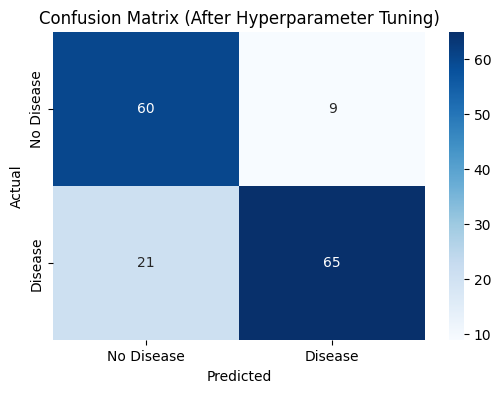

In [47]:
# Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix (After Hyperparameter Tuning)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

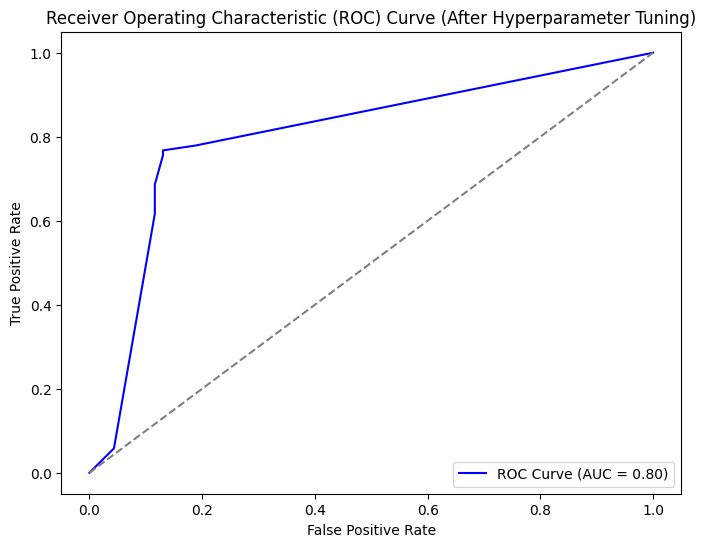

In [48]:
# ROC Curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve (After Hyperparameter Tuning)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

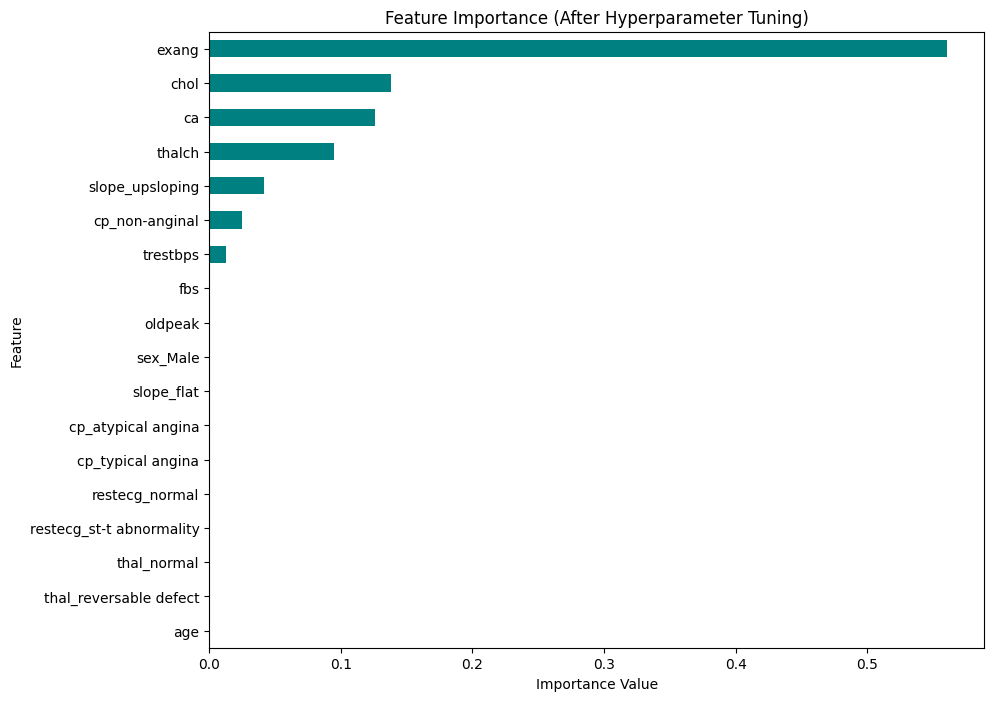

In [49]:
# Feature Importance
feature_importance_best = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance_best = feature_importance_best.sort_values()

plt.figure(figsize=(10, 8))
feature_importance_best.plot(kind='barh', color='teal')
plt.title('Feature Importance (After Hyperparameter Tuning)')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.show()